In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
with open('train_df') as f:
    X_train = pd.read_csv(f)

with open('test_df') as f:
    X_test = pd.read_csv(f)

with open('val_df') as f:
    X_val = pd.read_csv(f)

In [3]:
y_train=X_train.Cancer
y_test=X_test.Cancer
y_val=X_val.Cancer

X_train=X_train.drop("Cancer",axis=1)
X_test=X_test.drop("Cancer",axis=1)
X_val=X_val.drop("Cancer",axis=1)

columns=X_train.columns

In [4]:
# For PCA we decided to standardize all of the columns

sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
X_test_std=sc.fit_transform(X_test)
X_val_std=sc.fit_transform(X_val)

In [5]:
pca=PCA(n_components = 2).fit(X_train_std)

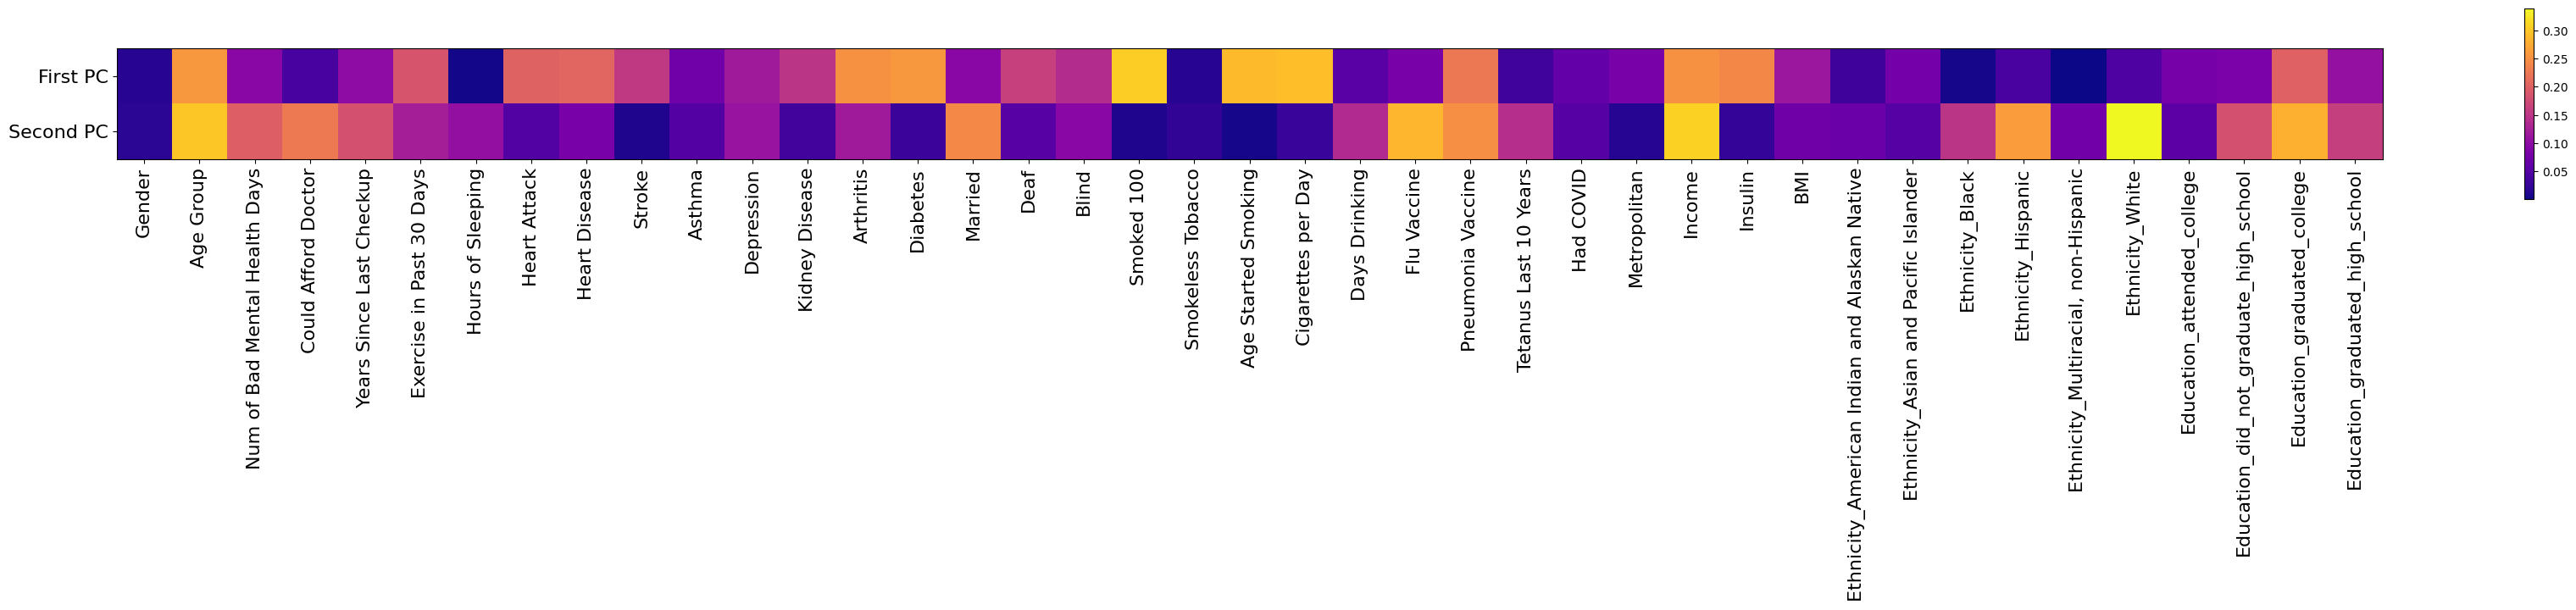

In [6]:
def plot_pca_heatmap(pca, feature_names):
    pc_names = ["First PC", "Second PC"]
    fig, ax = plt.subplots(figsize=(35, 6))

    plt.imshow(np.abs(pca.components_), interpolation="none", cmap="plasma")
    plt.xticks(np.arange(0, len(feature_names), 1), feature_names, rotation=90, fontsize=16)
    plt.yticks(np.arange(0.0, 2, 1), pc_names, fontsize=16)
    plt.colorbar()
    plt.tight_layout()

    return
plot_pca_heatmap(pca, columns)

In [7]:
loadings = pca.components_
features = []
for l in loadings:
    sorted_indices = np.argsort(np.abs(l))
    for i in range(3):
        index=sorted_indices[-i-1]
        features.append(columns[index])
features

['Smoked 100',
 'Cigarettes per Day',
 'Age Started Smoking',
 'Ethnicity_White',
 'Income',
 'Age Group']

In [10]:
def create_biplot(pca,data,loadings,features):
    X=pca.transform(data)
    #Creating dictionary for column names to map to indices
    dic={name:i for i,name in enumerate(columns) if name in features}
    x_score = X[:,0]
    y_score = X[:,1]
    x_scale = 3.0 / (x_score.max() - x_score.min())
    y_scale = 3.0 / (y_score.max() - y_score.min())

    plt.figure(figsize=(8,8))
    plt.scatter(x_score * x_scale, y_score * y_scale, s = .9, alpha = .5)
    for name, i in dic.items():
        plt.arrow(0,0,loadings[0,i]*2,loadings[1,i]*2,color = 'red')
        plt.text(loadings[0,i] * 2,loadings[1,i]*2,name,color='black',ha='left',va='top',fontsize='x-large',rotation=315)

    plt.xlim(-1, 1)
    plt.ylim(-1, .5)
    plt.xlabel("Principal Component 1",fontsize=18)
    plt.ylabel("Principal Component 2",fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.tight_layout()


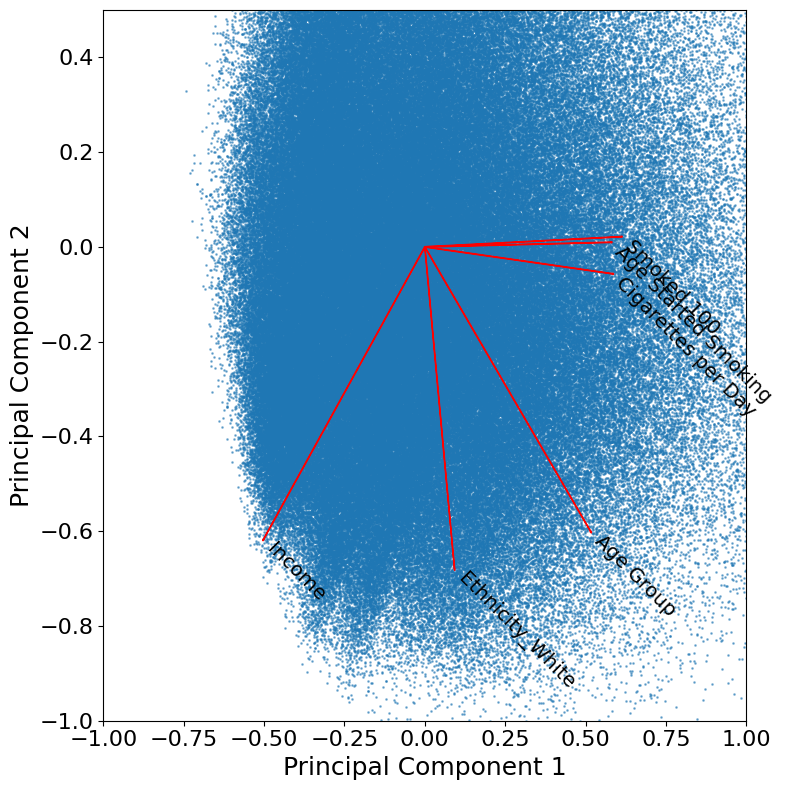

In [11]:
#top_features = ['Cigarettes per Day','Arthritis','Weight in Pounds','Metropolitan','Gender']
create_biplot(pca,X_train_std,loadings=loadings, features = features)
plt.grid()
plt.savefig('biplot')

In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_std, y_train)

In [11]:
# creating PCA with 33 components so that we can capture 95% of the variance as seen in the output below
pca=PCA(n_components = 33).fit(X_train_res)
sum = np.cumsum(pca.explained_variance_ratio_)
sum

array([0.09872117, 0.1678804 , 0.22932661, 0.27209261, 0.31472745,
       0.35446828, 0.389435  , 0.42211243, 0.45413086, 0.48543625,
       0.51450872, 0.54166118, 0.56731845, 0.59196156, 0.61564608,
       0.63885443, 0.66190859, 0.6841774 , 0.70583895, 0.72725348,
       0.74780641, 0.7681917 , 0.78786527, 0.80710314, 0.82594295,
       0.84381037, 0.86143434, 0.87865038, 0.89579145, 0.91282145,
       0.92818271, 0.94173099, 0.9546571 ])

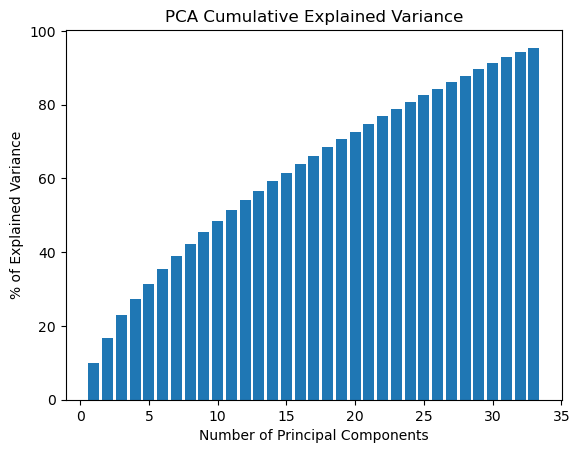

In [16]:
plt.bar(list(np.arange(1,34)),sum*100)
plt.xlabel('Number of Principal Components')
plt.ylabel('% of Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.savefig('Explained_variance')

In [13]:
X_train_trans=pca.transform(X_train_res)

In [14]:
X_val_trans=pca.transform(X_val)

/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [15]:
X_test_trans=pca.transform(X_test)

/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


## PCA with Naive Bayes

In [16]:
# Baseline Naive Bayes Model
nb = GaussianNB()
nb.fit(X_train_trans, y_train_res)

y_pred = nb.predict(X_test_trans)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test Scores')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('********************')
%time

Test Scores
Accuracy: 0.8862938200216841
Precision: 0.18181818181818182
Recall: 0.00039785160135269546
F1 Score: 0.000793965859468043
********************
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs


In [23]:
# NB pipeline with PCA

# First we make sure we create a pipeline to avoid data leakage
nb_pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA()),
    ('nb', GaussianNB())
])

# NB Parameter Grid 
# Using optimal parameters from best supervised model
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'pca__n_components': [33], # using 33 components to capture 95% of the variance
    'nb__var_smoothing': [.6,.5,.4]
}

# Grid search with raw data to avoid data leakage
grid_search = GridSearchCV(estimator=nb_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Cross-validation recall: ", np.round(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_],4))
print("Cross-validation recall std: ", np.round(grid_search.cv_results_['std_test_recall'][grid_search.best_index_],4))
print("Cross-validation precision: ", np.round(grid_search.cv_results_['mean_test_precision'][grid_search.best_index_],4))
print("Cross-validation precision std: ", np.round(grid_search.cv_results_['std_test_precision'][grid_search.best_index_],4))
print("Cross-validation f1 score: ", np.round(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_],4))
print("Cross-validation f1 std: ", np.round(grid_search.cv_results_['std_test_f1'][grid_search.best_index_],4))
print("Cross-validation accuracy score: ", np.round(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],4))
print("Cross-validation accuracy std: ", np.round(grid_search.cv_results_['std_test_accuracy'][grid_search.best_index_],4))

grid_nb = grid_search.best_estimator_
print(grid_nb)  

print('********************')
%time

Best parameters found:  {'nb__var_smoothing': 0.5, 'pca__n_components': 33}
Cross-validation recall:  0.8231
Cross-validation recall std:  0.003
Cross-validation precision:  0.1826
Cross-validation precision std:  0.0013
Cross-validation f1 score:  0.2989
Cross-validation f1 std:  0.0016
Cross-validation accuracy score:  0.5615
Cross-validation accuracy std:  0.0042
Pipeline(steps=[('sc', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('pca', PCA(n_components=33)),
                ('nb', GaussianNB(var_smoothing=0.5))])
********************
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 8.34 µs


In [24]:
# Testing Grid Search sgdc
y_pred = grid_nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test Scores')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Test Scores
Accuracy: 0.5664980122876762
Precision: 0.1838028483414438
Recall: 0.8189775213845236
F1 Score: 0.3002260628600598


# PCA with SGDClassifier

In [25]:
# Baseline SGDClassifier Model
sgdc = SGDClassifier()
sgdc.fit(X_train_trans, y_train_res)

y_pred = sgdc.predict(X_test_trans)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test Scores')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('********************')
%time

Test Scores
Accuracy: 0.5737034694615106
Precision: 0.18739275715704867
Recall: 0.825542072806843
F1 Score: 0.3054502631288411
********************
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [32]:
# sgdc pipeline with PCA

# First we make sure we create a pipeline to avoid data leakage
sgdc_pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA()),
    ('sgdc', SGDClassifier())
])

# sgdc Parameter Grid 
# Using optimal parameters from best supervised model
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'pca__n_components': [33], # using 33 components to capture 95% of the variance
    'sgdc__alpha': [1.1,1.2,1.3], 
    'sgdc__eta0': [.4,.5,.6], 
    'sgdc__learning_rate': ['adaptive'], 
    'sgdc__loss': ['hinge'], 
    'sgdc__penalty': ['l2']
}

# Grid search with raw data to avoid data leakage
grid_search = GridSearchCV(estimator=sgdc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Cross-validation recall: ", np.round(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_],4))
print("Cross-validation recall std: ", np.round(grid_search.cv_results_['std_test_recall'][grid_search.best_index_],4))
print("Cross-validation precision: ", np.round(grid_search.cv_results_['mean_test_precision'][grid_search.best_index_],4))
print("Cross-validation precision std: ", np.round(grid_search.cv_results_['std_test_precision'][grid_search.best_index_],4))
print("Cross-validation f1 score: ", np.round(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_],4))
print("Cross-validation f1 std: ", np.round(grid_search.cv_results_['std_test_f1'][grid_search.best_index_],4))
print("Cross-validation accuracy score: ", np.round(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],4))
print("Cross-validation accuracy std: ", np.round(grid_search.cv_results_['std_test_accuracy'][grid_search.best_index_],4))

grid_sgdc = grid_search.best_estimator_
print(grid_sgdc)  

print('********************')
%time

Best parameters found:  {'pca__n_components': 33, 'sgdc__alpha': 1.2, 'sgdc__eta0': 0.5, 'sgdc__learning_rate': 'adaptive', 'sgdc__loss': 'hinge', 'sgdc__penalty': 'l2'}
Cross-validation recall:  0.7468
Cross-validation recall std:  0.0054
Cross-validation precision:  0.205
Cross-validation precision std:  0.0016
Cross-validation f1 score:  0.3216
Cross-validation f1 std:  0.0025
Cross-validation accuracy score:  0.6423
Cross-validation accuracy std:  0.0017
Pipeline(steps=[('sc', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('pca', PCA(n_components=33)),
                ('sgdc',
                 SGDClassifier(alpha=1.2, eta0=0.5, learning_rate='adaptive'))])
********************
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


In [33]:
# Testing Grid Search sgdc
y_pred = grid_sgdc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test Scores')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Test Scores
Accuracy: 0.6382589447054572
Precision: 0.20267344950752245
Recall: 0.7449771235329222
F1 Score: 0.318655605190385


## PCA with Random Forest Classifier

In [36]:
# Baseline RFC Model
rfc = RandomForestClassifier()
rfc.fit(X_train_trans, y_train_res)

y_pred = rfc.predict(X_test_trans)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test Scores')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('********************')
%time

Test Scores
Accuracy: 0.8861131189013371
Precision: 0.058823529411764705
Recall: 0.00019892580067634773
F1 Score: 0.0003965107057890563
********************
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.82 µs


In [44]:
# RFC pipeline with PCA

# First we make sure we create a pipeline to avoid data leakage
rfc_pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA()),
    ('rfc', RandomForestClassifier())
])

# RFC Parameter Grid 
# Using optimal parameters from best supervised model
# Note: more values have been tested than what is shown, small amounts of values were run at a time to increase runtime.
param_grid = {
    'pca__n_components': [33], # using 33 components to capture 95% of the variance
    'rfc__n_estimators': [1,2], 
    'rfc__criterion': ['gini'], #using gini to optimize run time
    'rfc__max_depth': [3,4,5], 
    'rfc__random_state': [42]
}

# Grid search with raw data to avoid data leakage
grid_search = GridSearchCV(estimator=rfc_pipeline, param_grid=param_grid, cv=5, scoring=['recall','precision','f1','accuracy'],refit='recall')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Cross-validation recall: ", np.round(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_],4))
print("Cross-validation recall std: ", np.round(grid_search.cv_results_['std_test_recall'][grid_search.best_index_],4))
print("Cross-validation precision: ", np.round(grid_search.cv_results_['mean_test_precision'][grid_search.best_index_],4))
print("Cross-validation precision std: ", np.round(grid_search.cv_results_['std_test_precision'][grid_search.best_index_],4))
print("Cross-validation f1 score: ", np.round(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_],4))
print("Cross-validation f1 std: ", np.round(grid_search.cv_results_['std_test_f1'][grid_search.best_index_],4))
print("Cross-validation accuracy score: ", np.round(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],4))
print("Cross-validation accuracy std: ", np.round(grid_search.cv_results_['std_test_accuracy'][grid_search.best_index_],4))

grid_rfc = grid_search.best_estimator_
print(grid_rfc)  

print('********************')
%time

Best parameters found:  {'pca__n_components': 33, 'rfc__criterion': 'gini', 'rfc__max_depth': 4, 'rfc__n_estimators': 1, 'rfc__random_state': 42}
Cross-validation recall:  0.8151
Cross-validation recall std:  0.0319
Cross-validation precision:  0.1739
Cross-validation precision std:  0.0053
Cross-validation f1 score:  0.2864
Cross-validation f1 std:  0.005
Cross-validation accuracy score:  0.5383
Cross-validation accuracy std:  0.0287
Pipeline(steps=[('sc', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('pca', PCA(n_components=33)),
                ('rfc',
                 RandomForestClassifier(max_depth=4, n_estimators=1,
                                        random_state=42))])
********************
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [45]:
# Testing Grid Search sgdc
y_pred = grid_rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Test Scores')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Test Scores
Accuracy: 0.5155854716299241
Precision: 0.16909186182433794
Recall: 0.8344937338372787
F1 Score: 0.2812039147338785
